<a href="https://colab.research.google.com/github/meganlcole327/MLA_MLC/blob/main/FinalProject_Regression_MLC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Final Project - Regression

CS 430 - ON

Machine Learning in the Cloud

Megan Cole

#Standard Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Specific Imports

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


#Imports for Splitting Data and Building Pipeline

In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn import set_config
set_config(display='diagram')

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

#Imports for Performance Measures


In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc


#Confusion Matrix Function

In [7]:
def plot_cm(y_test, y_pred):
    cm = confusion_matrix(y_test,y_pred)
    fig = plt.figure(figsize=(10,10))
    heatmap = sns.heatmap(cm, annot=True, fmt='.2f', cmap='RdYlGn')
    plt.ylabel('True label')
    plt.xlabel('Predicted Label')

#ROC_Curve Function

In [8]:
def plot_roc_curve(fpr,tpr):
  plt.plot(fpr, tpr, linewidth=2)
  plt.plot([0,1],[0,1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])

#Problem 1 - Regression

#Aquire Data

Reading the Data:

The dataset contains information about secondary students in Portugal, including academic performance, family background, and study habits. The target variable we are predicting is the final math grade (G3), which is a continuous value suitable for regression.

Dataset Citation:

Cortez, P. (2008). Student Performance [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5TG7T.

In [9]:
file_path = '/content/gdrive/MyDrive/BU/CS430/student-mat.csv'
df = pd.read_csv(file_path, delimiter=';')

df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


#Statistics and Visual Exploration

This section summarizes the dataset and examines feature distributions. This helps us identify patterns, potential outliers, and relationships between variables.


In [10]:
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

In [ ]:
#Counts for columns
for col in df.select_dtypes(include='object').columns:
    print(f"\nValue counts for '{col}':")
    print(df[col].value_counts())


Value counts for 'school':
school
GP    349
MS     46
Name: count, dtype: int64

Value counts for 'sex':
sex
F    208
M    187
Name: count, dtype: int64

Value counts for 'address':
address
U    307
R     88
Name: count, dtype: int64

Value counts for 'famsize':
famsize
GT3    281
LE3    114
Name: count, dtype: int64

Value counts for 'Pstatus':
Pstatus
T    354
A     41
Name: count, dtype: int64

Value counts for 'Mjob':
Mjob
other       141
services    103
at_home      59
teacher      58
health       34
Name: count, dtype: int64

Value counts for 'Fjob':
Fjob
other       217
services    111
teacher      29
at_home      20
health       18
Name: count, dtype: int64

Value counts for 'reason':
reason
course        145
home          109
reputation    105
other          36
Name: count, dtype: int64

Value counts for 'guardian':
guardian
mother    273
father     90
other      32
Name: count, dtype: int64

Value counts for 'schoolsup':
schoolsup
no     344
yes     51
Name: count, dtype: in

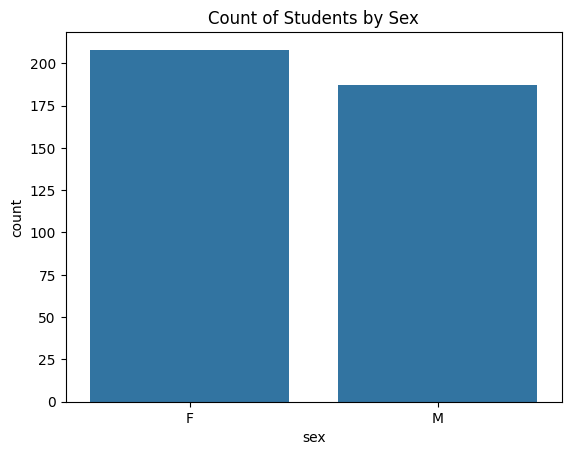

In [11]:
# Bar plot for Sex of students
sns.countplot(data=df, x='sex')
plt.title("Count of Students by Sex")
plt.show()


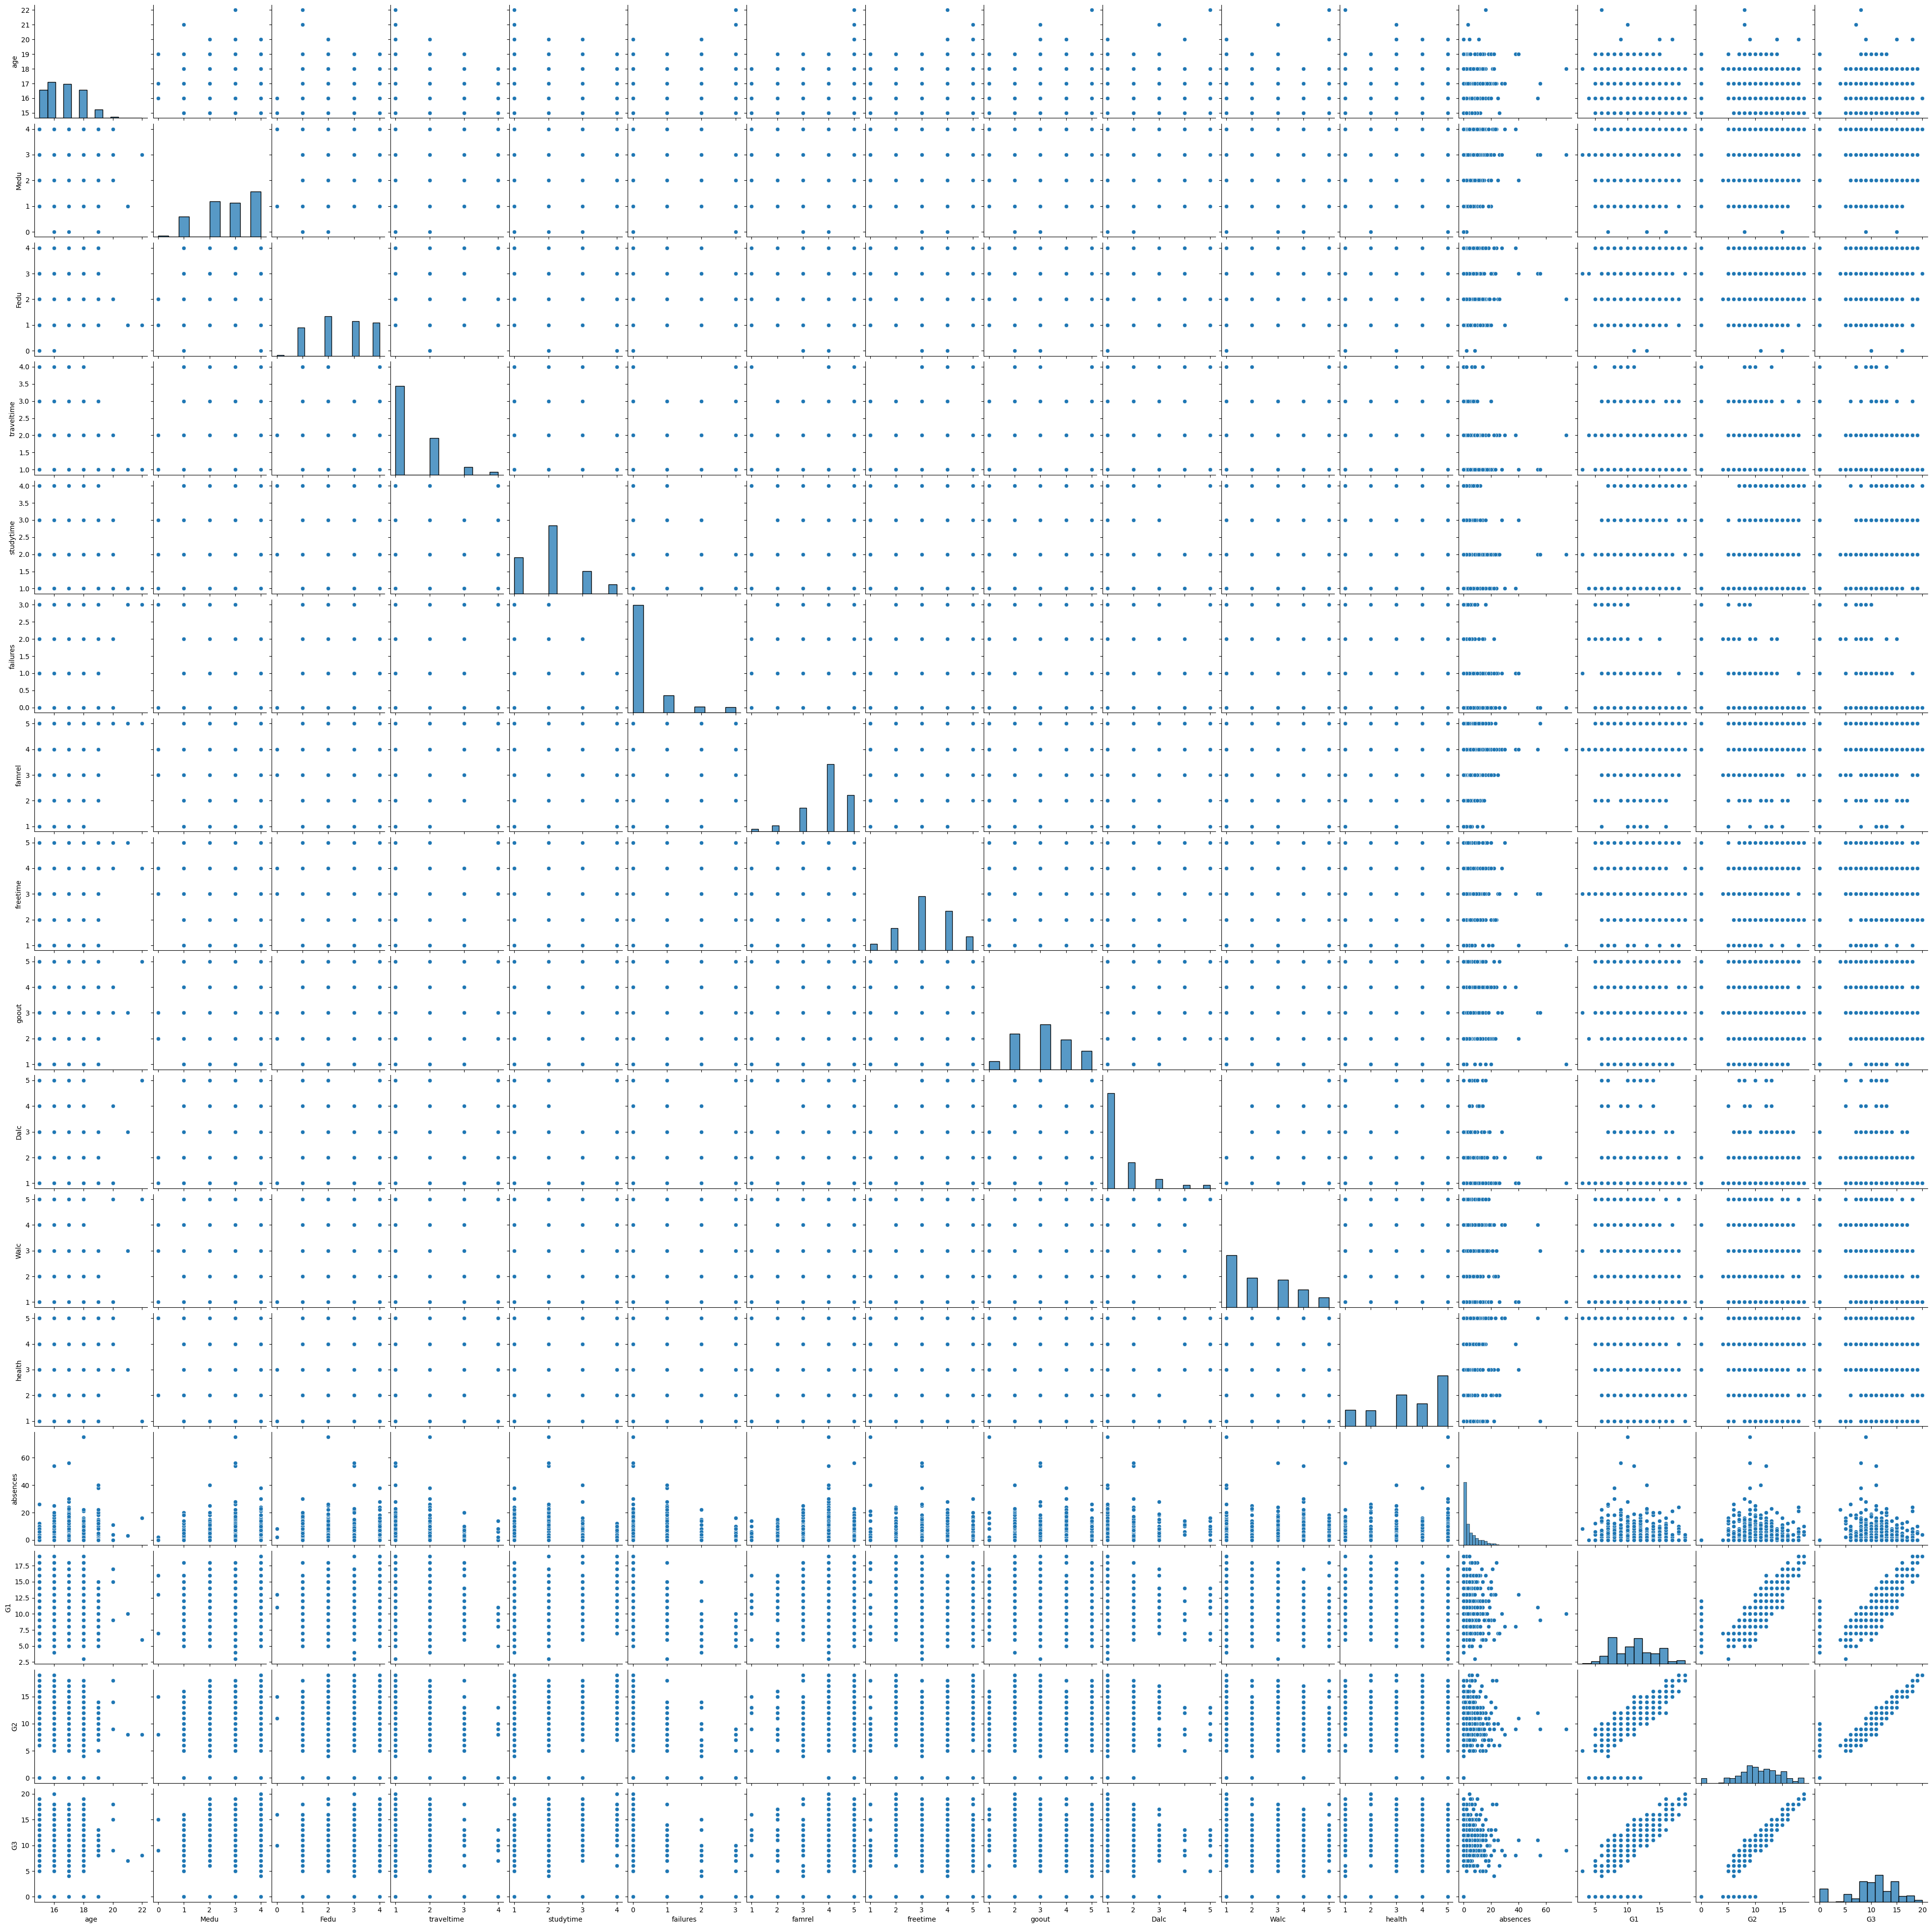

In [12]:
# Pair plot
sns.pairplot(df.select_dtypes(include=['int64', 'float64']))
plt.show()

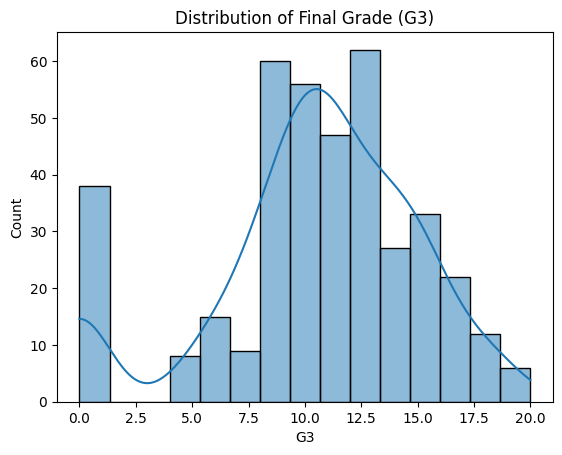

In [13]:
#Histogram
sns.histplot(df['G3'], bins=15, kde=True)
plt.title('Distribution of Final Grade (G3)')
plt.show()


#Splitting Data into Train/Test

In [14]:
X = df.drop(columns=['G3'])
y = df['G3']

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = MinMaxScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#Build the Pipeline

In [15]:
lr_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', LinearRegression())
])

svr_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', SVR())
])


#Execute the Model

In [16]:
#Linear Regression
lr_pipeline.fit(X_train, y_train)

#SVR
param_grid = {
    'regressor__C': [0.1, 1, 10],
    'regressor__epsilon': [0.1, 0.2]
}

grid_search_svr = GridSearchCV(svr_pipeline, param_grid, cv=5)
grid_search_svr.fit(X_train, y_train)
best_svr_pipeline = grid_search_svr.best_estimator_

#Evaluate the Model

In [24]:
rmse_train_lr = np.sqrt(np.mean((y_train - y_train_pred_lr) ** 2))
rmse_test_lr = np.sqrt(np.mean((y_test - y_test_pred_lr) ** 2))

rmse_train_svr = np.sqrt(np.mean((y_train - y_train_pred_svr) ** 2))
rmse_test_svr = np.sqrt(np.mean((y_test - y_test_pred_svr) ** 2))

print(f"Linear Regression Train RMSE: {rmse_train_lr:.2f}")
print(f"Linear Regression Test RMSE: {rmse_test_lr:.2f}")
print(f"SVR Train RMSE: {rmse_train_svr:.2f}")
print(f"SVR Test RMSE: {rmse_test_svr:.2f}")


Linear Regression Train RMSE: 1.68
Linear Regression Test RMSE: 2.38
SVR Train RMSE: 1.27
SVR Test RMSE: 2.53


#Conclusion

This project used regression to predict students' final math grades using demographic, behavioral, and academic features. While SVR had the lowest training RMSE, its test RMSE was slightly higher compared to linear regression. This indicates that SVR may have slightly overfit the training data. While linear regression performed more consistently across both sets, suggesting better generalization for this dataset. Therefore, I think linear regression is better to use in this dataset.
